In [1]:
# Paquetes a importar
import copy
import numpy as np
from IPython.display import Image
from matplotlib import pyplot as plt
import math

In [2]:
import numpy as np
import copy

MAP1 = ["s0",
        "0g"]

MAP2 = ["s0100",
        "00100",
        "00100",
        "00000",
        "0000g"]

MAP3 = ["s0100000",
        "00100000",
        "00100100",
        "00100100",
        "00000100",
        "0000010g"]

MAP4 = ["s0100001g0000",
        "0010000111100",
        "0010010100000",
        "0010010101000",
        "0000010101001",
        "0000010001000"]


class GridWorld(object):
    EMPTY = 0
    HOLE = 1
    START = 2
    GOAL = 3

    ACTION_UP = 0
    ACTION_RIGHT = 1
    ACTION_DOWN = 2
    ACTION_LEFT = 3

    def __init__(self, map_string, stochastic=False):
        self._parse_string(map_string)
        self.reset()
        self.max_steps = self.get_num_states()
        self.fall_reward = -100
        self.goal_reward = 100
        self.step_reward = -1
        self.stochastic = stochastic

    def get_num_states(self):
        return self.n_rows * self.n_cols

    def get_num_actions(self):
        return 4

    # Resets the grid world to the starting position
    def reset(self):
        self.loc = copy.deepcopy(self.start)
        self.step_iter = 0
        return self._flatten_idx(self.loc)

    # Takes an action "u", which is one of
    # [GridWorld.ACTION_UP, GridWorld.ACTION_RIGHT, GridWorld.ACTION_DOWN, GridWorld.ACTION_LEFT]
    # this function will return a tuple of
    # (next_state, reward, done)
    # where
    # next state is the state of the system after taking action "u"
    # reward is the one-step reward
    # done is a boolean saying whether or not the episode has ended.
    # if done is true, you have to call reset() before you can call step() again
    def step(self, u):

        stochastic_prob = 0.7
        if self.stochastic:
            if u == GridWorld.ACTION_UP:
                u_new = np.random.choice(
                    [GridWorld.ACTION_UP, GridWorld.ACTION_LEFT, GridWorld.ACTION_RIGHT],
                    p=[stochastic_prob, 0.5*(1-stochastic_prob), 0.5*(1-stochastic_prob)])
            elif u == GridWorld.ACTION_RIGHT:
                u_new = np.random.choice(
                    [GridWorld.ACTION_RIGHT, GridWorld.ACTION_UP, GridWorld.ACTION_DOWN],
                    p=[stochastic_prob, 0.5*(1-stochastic_prob), 0.5*(1-stochastic_prob)])
            elif u == GridWorld.ACTION_DOWN:
                u_new = np.random.choice(
                    [GridWorld.ACTION_DOWN, GridWorld.ACTION_LEFT, GridWorld.ACTION_RIGHT],
                    p=[stochastic_prob, 0.5*(1-stochastic_prob), 0.5*(1-stochastic_prob)])
            elif u == GridWorld.ACTION_LEFT:
                u_new = np.random.choice(
                    [GridWorld.ACTION_LEFT, GridWorld.ACTION_UP, GridWorld.ACTION_DOWN],
                    p=[stochastic_prob, 0.5*(1-stochastic_prob), 0.5*(1-stochastic_prob)])
        else:
            u_new = u

        if u_new == GridWorld.ACTION_UP:
            self.loc[0] -= 1
        elif u_new == GridWorld.ACTION_DOWN:
            self.loc[0] += 1
        elif u_new == GridWorld.ACTION_RIGHT:
            self.loc[1] += 1
        elif u_new == GridWorld.ACTION_LEFT:
            self.loc[1] -= 1
        else:
            raise Exception("Not a valid action")

        out_of_bounds = False
        if self.loc[0] < 0:
            self.loc[0] = 0
            out_of_bounds = True
        if self.loc[0] >= self.n_rows:
            self.loc[0] = self.n_rows - 1
            out_of_bounds = True
        if self.loc[1] < 0:
            self.loc[1] = 0
            out_of_bounds = True
        if self.loc[1] >= self.n_cols:
            self.loc[1] = self.n_cols - 1
            out_of_bounds = True

        self.step_iter += 1


        goal_reached = (self.loc == self.goal)
        if (out_of_bounds):
            return self._flatten_idx(self.loc), self.fall_reward, True
        if self.map[self.loc[0], self.loc[1]] == GridWorld.HOLE:
            return self._flatten_idx(self.loc), self.fall_reward, True
        if goal_reached:
            return self._flatten_idx(self.loc), self.goal_reward, True
        if self.step_iter == self.max_steps:
            return self._flatten_idx(self.loc), self.step_reward, True
        return self._flatten_idx(self.loc), self.step_reward, False

    def print(self):
        print_str = ""
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if self.loc == [row, col]:
                    print_str += "*"
                else:
                    print_str += str(self.map[row, col])
            print_str += "\n"
        print(print_str)

    def _flatten_idx(self, idx):
        flattened = idx[0] * self.n_cols + idx[1]
        return flattened

    def _unflatten_idx(self, idx):
        i = int(math.floor(loc / self.n_cols))
        j = idx - (i * self.n_cols)
        unflattened = (i, j)
        return unflattened

    def _parse_string(self, map_string):
        assert(len(map_string) > 0)
        assert(len(map_string[0]) > 0)

        self.n_rows = len(map_string)
        self.n_cols = len(map_string[0])

        self.map = np.zeros((self.n_rows, self.n_cols), dtype=np.int8)
        symbol_dict = {
            "0" : GridWorld.EMPTY,
            "1" : GridWorld.HOLE,
            "s" : GridWorld.START,
            "g" : GridWorld.GOAL}

        for row_idx, row in enumerate(map_string):
            assert(len(row) == self.n_cols)
            for col_idx in range(self.n_cols):
                assert(row[col_idx] in symbol_dict.keys())
                self.map[row_idx, col_idx] = symbol_dict[row[col_idx]]
                if row[col_idx] == 's':
                    self.start = [row_idx, col_idx]
                if row[col_idx] == 'g':
                    self.goal = [row_idx, col_idx]

In [3]:
def EpsilonGreedyPolicy(q, eps, state):
  """
  Implement epsilon-greedy policy.

  Given a table (q), a state (state) and a probability (eps),
  it returns an integer between 0 y 3 representing the action.
  """

  sample = np.random.random_sample()
  num_actions = q.shape[1]

  if sample > eps:
    #COMPLETE
    action = np.argmax(q[state])
  else:
    #COMPLETE
    action = np.random.choice(num_actions)
  return action

class TabularTD(object):
  """
  Implements a Q-learning agent.

    """
  def __init__(self, num_states, num_actions, gamma=0.95, alpha=0.5):
      self.num_states = num_states
      self.num_actions = num_actions
      self.alpha = alpha
      self.gamma = gamma
      self.reset()

  def reset(self):
    self.Q = np.zeros((self.num_states, self.num_actions))
    return


  def update(self, state, action, reward, next_state, done):
    # TODO
    # Update the entry of the table for the pair (state, action)
    # Warning: if done=True the episode ended
    best_next_action = np.argmax(self.Q[next_state]) if not done else 0
    target = reward + self.gamma * self.Q[next_state, best_next_action] * (1 - done)
    self.Q[state, action] += self.alpha * (target - self.Q[state, action])

    return

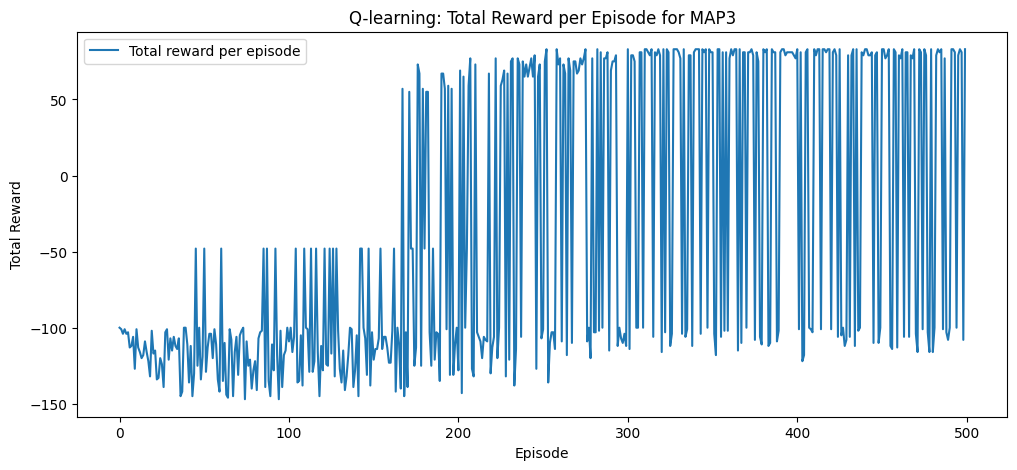

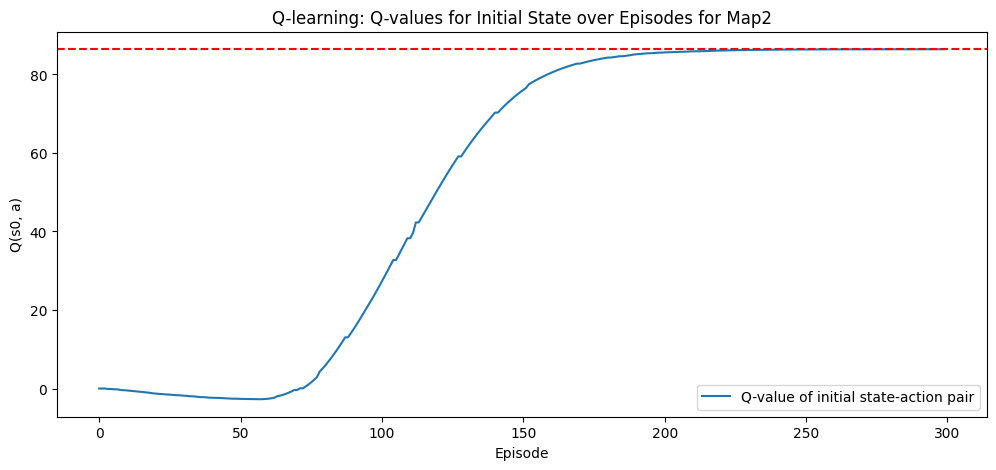

The Q Table at Episode 130 which is right before the Algorithim Converges
[[-46.8559       0.37892428  86.41132307 -77.12320755]
 [-19.         -19.          16.15773543  -2.26593914]
 [  0.           0.           0.           0.        ]
 [-10.           0.           0.           0.        ]
 [-10.           0.           0.           0.        ]
 [ 25.11343134   9.52585459  88.29555024 -40.951     ]
 [ -1.73349717 -27.1         62.46509787  -1.72862811]
 [  0.           0.           0.           0.        ]
 [ -0.1          0.           0.           0.        ]
 [ -0.1          0.           0.           0.        ]
 [ 14.36875744  90.19788957   5.82865552 -40.951     ]
 [  6.42514647 -40.951       92.11917586  24.69380006]
 [  0.           0.           0.           0.        ]
 [ -0.1         -0.1          0.           0.        ]
 [ -0.1        -10.           0.           0.        ]
 [  7.97341514  59.656068    -0.31082361 -10.        ]
 [ 38.56995967  23.33495213  94.05979518  21.7

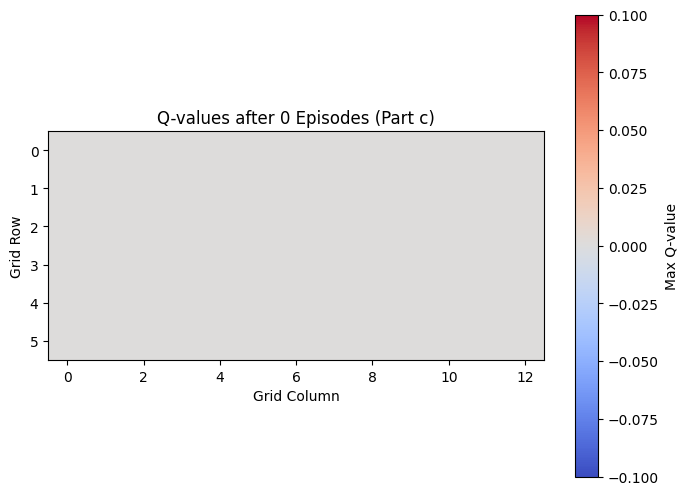

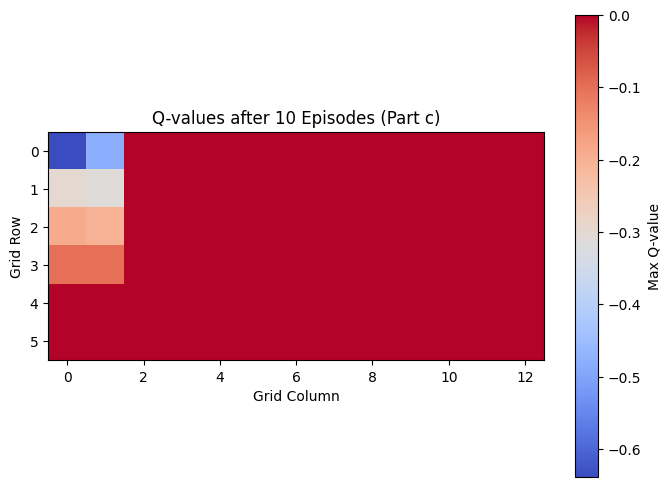

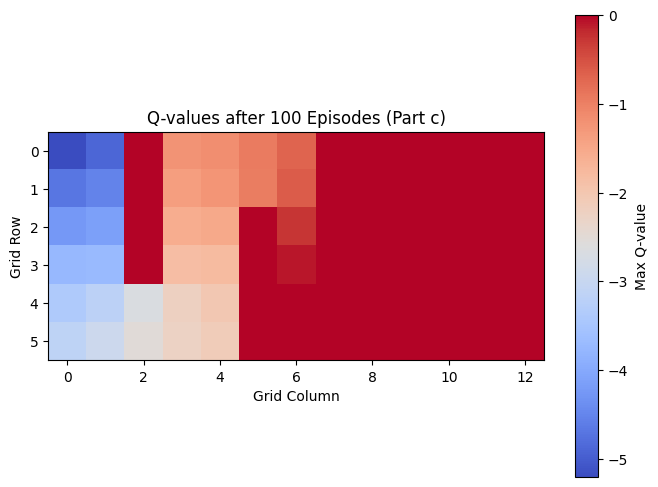

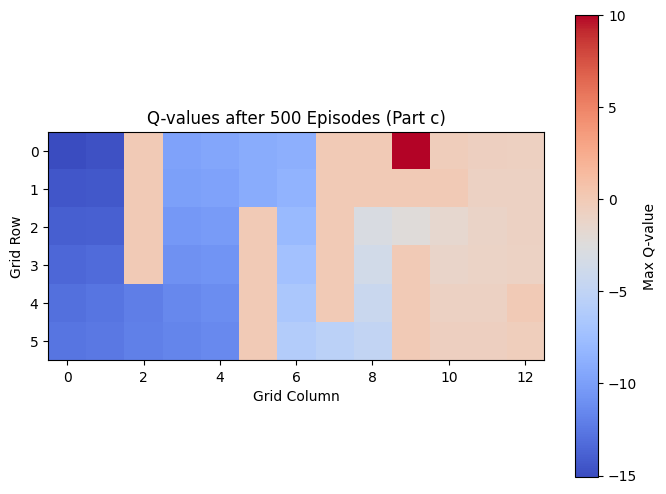

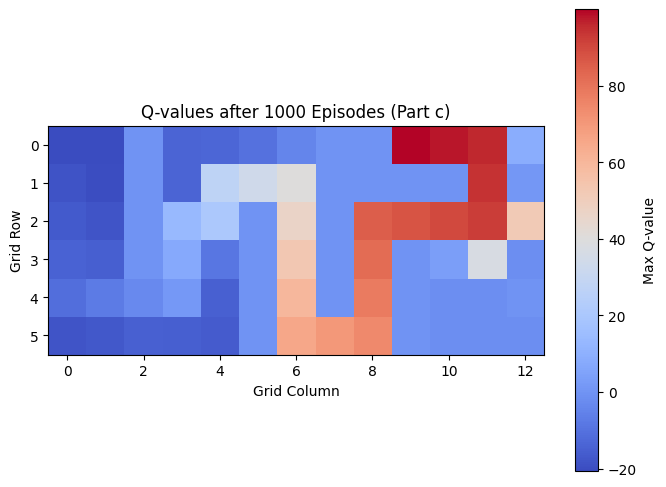

In [4]:
import matplotlib.pyplot as plt

env = GridWorld(MAP3)
gamma = .99
alpha = .1
eps = .1

qlearning = TabularTD(env.get_num_states(), env.get_num_actions(),
                      alpha=alpha, gamma=gamma)

reward_hist = []
s0_return = []

num_episodes = 500
for i in range(num_episodes):
    state = env.reset()
    done = False

    reward_list = []

    action = EpsilonGreedyPolicy(qlearning.Q, 0, state)
    s0_return.append(qlearning.Q[state, action])
    while not done:
        action = EpsilonGreedyPolicy(qlearning.Q, eps, state)
        next_state, reward, done = env.step(action)
        reward_list.append(reward)
        qlearning.update(state, action, reward, next_state, done)
        state = next_state
    reward_hist.append(np.sum(reward_list))



#TODO: PLOT RESULTS
plt.figure(figsize=(12, 5))
plt.plot(reward_hist, label='Total reward per episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning: Total Reward per Episode for MAP3')
plt.legend()
plt.show()

env = GridWorld(MAP2)
gamma = .99
alpha = .1
eps = .1

qlearning = TabularTD(env.get_num_states(), env.get_num_actions(),
                      alpha=alpha, gamma=gamma)

reward_hist = []
s0_return = []

num_episodes = 300
for i in range(num_episodes):
    state = env.reset()
    done = False

    reward_list = []
    if i == 150:
        qtable = qlearning.Q

    action = EpsilonGreedyPolicy(qlearning.Q, 0, state)
    s0_return.append(qlearning.Q[state, action])
    while not done:
        action = EpsilonGreedyPolicy(qlearning.Q, eps, state)
        next_state, reward, done = env.step(action)
        reward_list.append(reward)
        qlearning.update(state, action, reward, next_state, done)
        state = next_state
    reward_hist.append(np.sum(reward_list))



# Plot Q-values of initial state (s0)
plt.figure(figsize=(12, 5))
plt.plot(s0_return, label='Q-value of initial state-action pair')
plt.axhline(y=s0_return[250], color='r', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Q(s0, a)')
plt.title('Q-learning: Q-values for Initial State over Episodes for Map2')
plt.legend()
plt.show()

print("The Q Table at Episode 130 which is right before the Algorithim Converges")
print(qtable)

env = GridWorld(MAP4)
gamma = .99
alpha = .1
eps = .1

qlearning = TabularTD(env.get_num_states(), env.get_num_actions(),
                      alpha=alpha, gamma=gamma)

q_value_snapshots = []

reward_hist = []
s0_return = []
epi_list = [0,10,100,500,1000]
num_episodes = 1000
for i in range(num_episodes+1):
    state = env.reset()
    done = False
        

    action = EpsilonGreedyPolicy(qlearning.Q, 0, state)
    s0_return.append(qlearning.Q[state, action])
    while not done:
        action = EpsilonGreedyPolicy(qlearning.Q, eps, state)
        next_state, reward, done = env.step(action)
        reward_list.append(reward)
        qlearning.update(state, action, reward, next_state, done)
        state = next_state
    reward_hist.append(np.sum(reward_list))
    if i in epi_list:
        q_value_snapshot = np.max(qlearning.Q, axis=1).reshape((env.n_rows, env.n_cols))
        q_value_snapshots.append((i, q_value_snapshot))


for (episodes, q_values) in q_value_snapshots:
    plt.figure(figsize=(8, 6))
    plt.imshow(q_values, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Max Q-value")
    plt.title(f"Q-values after {episodes} Episodes (Part c)")
    plt.xlabel("Grid Column")
    plt.ylabel("Grid Row")
    plt.show()


